Steps worth enriching later on :  
* duplicated entries (entries with most game played was kept, but it was also duplicated)  
* droping player missing is any of the dataset    

# <span style='color:purple'> Imports & settings

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from pathlib import Path

PENALTY_RATE = 1
POSITION_MAPPING = {'PG':1, 'SG':2, 'SF':3, 'PF':4, 'C':5}

from roster_lib.id_dict import pid2name, name2pid, pid2pos_bref
from roster_lib.preprocessing.loader import Loader
from roster_lib.utils.feature_handler import FeatureHandler
from roster_lib.clustering.clusterer import Clusterer
from roster_lib.clustering.partition_hdbscan import PartitionHDBSCAN
from roster_lib.constants import PREPROC_DATA_PATH

%reload_ext autoreload
%autoreload 2

In [18]:
from seaborn.palettes import SEABORN_PALETTES
import copy
BASE_PALETTE = copy.deepcopy(SEABORN_PALETTES['colorblind']) + copy.deepcopy(SEABORN_PALETTES['bright']) + copy.deepcopy(SEABORN_PALETTES['dark'])
if "#A3A3A3" in BASE_PALETTE:
    BASE_PALETTE.remove("#A3A3A3")

def _make_palette(clusters):
    pal = []
    neg = -1 in clusters
    if neg:
        pal.append("#A3A3A3")
    for i in range(len(clusters)-int(neg)):
        pal.append(BASE_PALETTE[i%len(BASE_PALETTE)])
    return pal

def create_palette(labels):
    clusters = np.unique(labels)
    return sns.color_palette(_make_palette(clusters))

# <span style='color:cyan'> Loader

### Duplicated handling

In [19]:
loader = Loader()
loader._load_raw_data()
for k,v in loader.raw_data.items():
    print(f"{k} - shape = {v.shape} - n° duplicated index = {v.index.duplicated().sum()}")
    # display(v.head(3))

Score - shape = (3131, 34) - n° duplicated index = 91
Misc - shape = (3066, 15) - n° duplicated index = 13
Defense - shape = (3045, 20) - n° duplicated index = 15
Pass - shape = (3092, 48) - n° duplicated index = 39
Rebound - shape = (3053, 25) - n° duplicated index = 0


In [21]:
issues = []
for k,v in loader.raw_data.items():
    for psid in v[v.index.duplicated()].index.unique():
        pid = int(psid.split('_')[0])
        sid = psid.split('_')[-1]
        if psid not in issues :
            issues.append(psid)
            print(f"{k:<12} - {pid2name[pid]:<20} - {sid} ({psid})") 

Score        - Jalen Jones          - 2017-18 (1627883_2017-18)
Score        - Delon Wright         - 2017-18 (1626153_2017-18)
Score        - Alfonzo McKinnie     - 2017-18 (1628035_2017-18)
Score        - Jakob Poeltl         - 2017-18 (1627751_2017-18)
Score        - Charles Cooke        - 2017-18 (1628429_2017-18)
Score        - ETwaun Moore         - 2017-18 (202734_2017-18)
Score        - Fred VanVleet        - 2017-18 (1627832_2017-18)
Score        - Cheick Diallo        - 2017-18 (1627767_2017-18)
Score        - Pascal Siakam        - 2017-18 (1627783_2017-18)
Score        - Darius Miller        - 2017-18 (203121_2017-18)
Score        - CJ Miles             - 2017-18 (101139_2017-18)
Score        - Jameer Nelson        - 2017-18 (2749_2017-18)
Score        - Lucas Nogueira       - 2017-18 (203512_2017-18)
Defense      - Quincy Pondexter     - 2014-15 (202347_2014-15)
Defense      - Corey Brewer         - 2017-18 (201147_2017-18)


In [4]:
# for psid in issues :
#     print(pid2name[int(psid.split('_')[0])])
#     for k,v in loader.raw_data.items():
#         if len(v.loc[psid].shape)>1 :
#             print(f"    {k}")

In [5]:
## Displays duplicated entries in "Score"

# for pl in issues :
#     print(f"{pid2name[int(pl.split('_')[0])]} - {pl.split('_')[-1]}")
#     display(data['Score'].loc[pl])

In [22]:
loader._handle_duplicated()

for k,v in loader.preproc_data.items():
    print(f"{k} - shape = {v.shape} - n° duplicated index = {v.index.duplicated().sum()}")

Score - shape = (3040, 34) - n° duplicated index = 0
Misc - shape = (3053, 15) - n° duplicated index = 0
Defense - shape = (3030, 20) - n° duplicated index = 0
Pass - shape = (3053, 48) - n° duplicated index = 0
Rebound - shape = (3053, 25) - n° duplicated index = 0


In [23]:
_tmp_list = []
partly_missing = []
for k,v in loader.preproc_data.items():
    for kk,vv in loader.preproc_data.items():
        n_missing = 0
        for id in v.index :
            if id not in vv.index:
                n_missing += 1
                if not id in partly_missing:
                    partly_missing.append(id)
        _tmp_list.append({'from': k , 'to': kk, 'missing':n_missing})
pd.DataFrame(_tmp_list).pivot(index = 'from', columns = 'to', values = 'missing')

to       Defense  Misc  Pass  Rebound  Score
from                                        
Defense        0     0     0        0      8
Misc          23     0     0        0     13
Pass          23     0     0        0     13
Rebound       23     0     0        0     13
Score         18     0     0        0      0

### Merging data

In [24]:
# Check if all minutes are relevant between datasets
# Impossible due to duplicate indices
_time_df = pd.concat([ v[['MIN']].rename(columns = {'MIN':k}) for k,v in loader.preproc_data.items() ], axis = 1)

_time_df['delta'] = _time_df.max(axis=1) - _time_df.min(axis = 1)
_time_df['name'] = [pid2name[int(x.split('_')[0])] for x in _time_df.index]
_time_df.sort_values('delta', ascending= False).head(10)

Score  Misc  Defense  Pass  Rebound  delta             name
pidSzn                                                                      
202713_2017-18     5.0   5.0      3.3   4.9      3.3    1.7     Kyle Singler
1628451_2017-18    6.7   6.7      8.1   6.7      8.1    1.4      Jacob Wiley
201587_2019-20    23.3  23.3     22.4  23.0     22.4    0.9    Nicolas Batum
1627733_2019-20   18.1  18.1     18.7  17.8     18.7    0.9    Dragan Bender
2199_2016-17      28.0  28.0     27.3  27.6     27.3    0.7   Tyson Chandler
1627761_2017-18   17.7  17.7     18.2  17.5     18.2    0.7   DeAndre Bembry
2030_2014-15       9.6   9.6     10.2   9.5     10.2    0.7    Kenyon Martin
2555_2017-18       5.1   5.1      4.4   5.0      4.4    0.7    Nick Collison
1629627_2019-20   28.2  28.2     27.5  27.8     27.5    0.7  Zion Williamson
1629130_2019-20   30.1  30.1     29.5  29.7     29.5    0.6  Duncan Robinson

In [28]:
loader.df.merge(loader.preproc_data['Score'][['MIN','GP']], left_index=True, right_index=True, how = 'left')

EFG_PCT  TS_PCT  USG_PCT   DD2  TD3  PTS_OFF_TOV  \
pidSzn                                                              
201985_2014-15     0.427   0.451    0.218   0.0  0.0          1.1   
201166_2014-15     0.495   0.534    0.246   1.0  0.0          0.8   
203932_2014-15     0.478   0.517    0.151   1.0  0.0          1.3   
203940_2014-15     0.416   0.443    0.173   3.0  0.0          0.9   
201143_2014-15     0.544   0.563    0.220  14.0  1.0          1.9   
...                  ...     ...      ...   ...  ...          ...   
203897_2019-20     0.526   0.568    0.312   2.0  0.0          4.6   
1629668_2019-20    0.375   0.402    0.147   0.0  0.0          0.0   
1629015_2019-20    0.273   0.313    0.165   0.0  0.0          0.1   
1629627_2019-20    0.592   0.616    0.291   2.0  0.0          3.0   
1629597_2019-20    0.667   0.667    0.103   0.0  0.0          1.0   

                 PTS_2ND_CHANCE  PTS_FB  PTS_PAINT  PTS_PER_ELBOW_TOUCH  ...  \
pidSzn                                                                   ...   
201985_2014-15              0.5     0.2        1.2                0.333  ...   
201166_2014-15              0.6     1.1        4.3                0.464  ...   
203932_2014-15              1.0     1.1        3.2                0.643  ...   
203940_2014-15              1.3     0.2        3.6                0.327  ...   
201143_2014-15              1.8     1.3        8.1                0.405  ...   
...                         ...     ...        ...                  ...  ...   
203897_2019-20              2.2     3.6       10.2                1.070  ...   
1629668_2019-20             0.0     0.6        0.0                0.000  ...   
1629015_2019-20             0.3     0.0        0.9                0.000  ...   
1629627_2019-20             4.3     3.6       17.0                0.829  ...   
1629597_2019-20             1.0     1.5        3.0                0.000  ...   

                 BOX_OUTS  BOX_OUT_PLAYER_TEAM_REBS  BOX_OUT_PLAYER_REBS  \
pidSzn                                                                     
201985_2014-15       0.00                      0.00                 0.00   
201166_2014-15       0.00                      0.00                 0.00   
203932_2014-15       0.00                      0.00                 0.00   
203940_2014-15       0.00                      0.00                 0.00   
201143_2014-15       0.00                      0.00                 0.00   
...                   ...                       ...                  ...   
203897_2019-20       0.87                      0.50                 0.15   
1629668_2019-20      0.00                      0.00                 0.00   
1629015_2019-20      0.14                      0.00                 0.00   
1629627_2019-20      1.17                      0.33                 0.29   
1629597_2019-20      0.75                      0.00                 0.00   

                 PCT_BOX_OUTS_OFF  PCT_BOX_OUTS_DEF  PCT_BOX_OUTS_TEAM_REB  \
pidSzn                                                                       
201985_2014-15              0.000             0.000                  0.000   
201166_2014-15              0.000             0.000                  0.000   
203932_2014-15              0.000             0.000                  0.000   
203940_2014-15              0.000             0.000                  0.000   
201143_2014-15              0.000             0.000                  0.000   
...                           ...               ...                    ...   
203897_2019-20              0.077             0.923                  0.882   
1629668_2019-20             0.000             0.000                  0.000   
1629015_2019-20             0.000             1.000                  0.000   
1629627_2019-20             0.071             0.929                  0.727   
1629597_2019-20             0.667             0.333                  0.000   

                 PCT_BOX_OUTS_REB  position   MIN  GP  
pidSzn            

### Data quality

In [9]:
_dupl_df =  pd.concat([v.drop(columns = ['MIN', 'GP', 'Season']) for v in loader.preproc_data.values()], axis = 1)
n_dupl = _dupl_df.index.duplicated().sum()
n_any_na = _dupl_df.isna().any(axis = 1).sum()
print(f"n° duplicated : {n_dupl} | n° line with n.a. : {n_any_na}")

n° duplicated : 0 | n° line with n.a. : 290


In [10]:
_dupl_df.isna().sum(axis = 0).sort_values()

OFF_LOOSE_BALLS_RECOVERED      0
SCREEN_AST_PTS                 0
PAINT_TOUCH_PASSES             0
DRIVE_PF_PCT                   0
DRIVE_PF                       0
                            ... 
D_FGM                         23
FREQ                          23
OPP_PTS_FB                    23
FG2_PCT                       36
FG3_PCT                      261
Length: 127, dtype: int64

In [11]:
display(loader.preproc_data['Score'][loader.preproc_data['Score']['FG3_PCT'].isna()][['FG3A_FREQUENCY', 'FG3A','FG3_PCT']].sort_values('FG3A').head(3))
display(loader.preproc_data['Score'][loader.preproc_data['Score']['FG2_PCT'].isna()][['FG2A_FREQUENCY', 'FG2A','FG2_PCT']].sort_values('FG2A').head(3))


FG3A_FREQUENCY  FG3A  FG3_PCT
pidSzn                                       
203945_2014-15             0.0   0.0      NaN
201582_2014-15             0.0   0.0      NaN
1905_2014-15               0.0   0.0      NaN

FG2A_FREQUENCY  FG2A  FG2_PCT
pidSzn                                       
203958_2014-15             0.0   0.0      NaN
203479_2014-15             0.0   0.0      NaN
203925_2015-16             0.0   0.0      NaN

In [12]:
max_time = 0
for pl in partly_missing:
    for v in loader.preproc_data.values():
        if pl in v.index :
            if v.loc[pl,'MIN'] > max_time :
                max_time = v.loc[pl,'MIN']
max_time

np.float64(9.8)

In [13]:

loader.df['position'].value_counts().sort_index()

position
1.0    594
2.0    680
3.0    524
4.0    626
5.0    584
Name: count, dtype: int64

# <span style ='color:chartreuse'>FeatureHandler

In [24]:
chs_v = sorted([int(f.split("_")[1].split(".")[0][1:]) for f in os.listdir(PREPROC_DATA_PATH / 'clustering') if 'features' in f])
chs_positions = [True, False, True, False, True, True] 
chs_positions = chs_positions+ [True] * (len(chs_v) - len(chs_positions))
for v, pos in zip(chs_v, chs_positions) :
    _ch = FeatureHandler(feature_version= v, use_positions=pos)
    print(len(_ch.incl), 'position' in _ch.incl) 
    

68 True
67 False
29 True
28 False
29 True
68 True
68 True
29 True
29 True
68 True
29 True
68 True
31 True
21 True


In [15]:
# with open("/home/admin/code/arnaud-odet/7_PhD/Roster/preproc_data/clustering/features_v1.json", "r") as f:
#     data = json.load(f)
# data['incl']

In [25]:
colinearity_handler = FeatureHandler(use_positions=True)
print(len(colinearity_handler.incl), 'position' in colinearity_handler.incl)

Initial number of features : 31
Top VIF = 380.2 - droping feature TS_PCT
Top VIF = 145.9 - droping feature PTS_PAINT
Top VIF = 116.9 - droping feature EFG_PCT
Top VIF = 82.1 - droping feature FG2A
Top VIF = 45.3 - droping feature FG2_PCT
Top VIF = 41.7 - droping feature USG_PCT
Top VIF = 34.5 - droping feature FG3A
Top VIF = 23.1 - droping feature PTS_OFF_TOV
Top VIF = 22.9 - droping feature PAINT_TOUCH_FG_PCT
Top VIF = 19.8 - droping feature CATCH_SHOOT_FG_PCT
Top VIF = 18.6 - droping feature PTS_2ND_CHANCE
Top VIF = 17.5 - droping feature PTS_PER_TOUCH
Top VIF = 13.0 - droping feature FG2A_FREQUENCY
Top VIF = 9.7 - stopping features exclusion with 18 feature retained
Initial number of features : 12
Top VIF = 96157.8 - droping feature DIST_MILES
Top VIF = 295.0 - droping feature DIST_MILES_OFF
Top VIF = 289.7 - droping feature AVG_SPEED
Top VIF = 141.4 - droping feature AVG_SPEED_DEF
Top VIF = 14.0 - droping feature DIST_MILES_DEF
Top VIF = 6.9 - stopping features exclusion with 7 fea

In [27]:
colinearity_handler.get_data('excl')

EFG_PCT  USG_PCT   DD2  TD3  PTS_OFF_TOV  PTS_2ND_CHANCE  \
pidSzn                                                                      
201985_2014-15     0.427    0.218   0.0  0.0          1.1             0.5   
201166_2014-15     0.495    0.246   1.0  0.0          0.8             0.6   
203932_2014-15     0.478    0.151   1.0  0.0          1.3             1.0   
203940_2014-15     0.416    0.173   3.0  0.0          0.9             1.3   
201143_2014-15     0.544    0.220  14.0  1.0          1.9             1.8   
...                  ...      ...   ...  ...          ...             ...   
203897_2019-20     0.526    0.312   2.0  0.0          4.6             2.2   
1629668_2019-20    0.375    0.147   0.0  0.0          0.0             0.0   
1629015_2019-20    0.273    0.165   0.0  0.0          0.1             0.3   
1629627_2019-20    0.592    0.291   2.0  0.0          3.0             4.3   
1629597_2019-20    0.667    0.103   0.0  0.0          1.0             1.0   

                 PTS_FB  PTS_PAINT  PTS_PER_ELBOW_TOUCH  PTS_PER_POST_TOUCH  \
pidSzn                                                                        
201985_2014-15      0.2        1.2                0.333               3.000   
201166_2014-15      1.1        4.3                0.464               0.000   
203932_2014-15      1.1        3.2                0.643               0.400   
203940_2014-15      0.2        3.6                0.327               0.344   
201143_2014-15      1.3        8.1                0.405               0.457   
...                 ...        ...                  ...                 ...   
203897_2019-20      3.6       10.2                1.070               0.450   
1629668_2019-20     0.6        0.0                0.000               0.000   
1629015_2019-20     0.0        0.9                0.000               0.000   
1629627_2019-20     3.6       17.0                0.829               0.503   
1629597_2019-20     1.5        3.0                0.000               0.000   

                 ...  OFF_BOXOUTS  DEF_BOXOUTS  BOX_OUT_PLAYER_TEAM_REBS  \
pidSzn           ...                                                       
201985_2014-15   ...         0.00         0.00                      0.00   
201166_2014-15   ...         0.00         0.00                      0.00   
203932_2014-15   ...         0.00         0.00                      0.00   
203940_2014-15   ...         0.00         0.00                      0.00   
201143_2014-15   ...         0.00         0.00                      0.00   
...              ...          ...          ...                       ...   
203897_2019-20   ...         0.07         0.80                      0.50   
1629668_2019-20  ...         0.00         0.00                      0.00   
1629015_2019-20  ...         0.00         0.14                      0.00   
1629627_2019-20  ...         0.08         1.08                      0.33   
1629597_2019-20  ...         0.50         0.25                      0.00   

                 BOX_OUT_PLAYER_REBS  PCT_BOX_OUTS_OFF  PCT_BOX_OUTS_DEF  \
pidSzn                                                                     
201985_2014-15                  0.00             0.000             0.000   
201166_2014-15                  0.00             0.000             0.000   
203932_2014-15                  0.00             0.000             0.000   
203940_2014-15                  0.00             0.000             0.000   
201143_2014-15                  0.00             0.000             0.000   
...                              ...               ...               ...   
203897_2019-20                  0.15             0.077             0.923   
1629668_2019-20                 0.00             0.000             0.000   
1629015_2019-20                 0.00             0.000             1.000   
1629627_2019-20                 0.29             0.071             0.929   
1629597_2019-20                 0.00             0.667             0.333   

         

In [28]:
colinearity_handler.compute_vifs()
for k,v in colinearity_handler.vifs.items():
    print(f"Feature Selection : {k}")
    display(v.round(2).head(5))

Feature Selection : incl


features  vif_index
1          EFG_PCT      55.84
0              MIN      52.02
3          FG2_PCT      39.58
17  DREB_UNCONTEST      21.61
2             FG2A      15.97

Feature Selection : excl


features  vif_index
115             MIN    1677.81
24   FG2A_FREQUENCY    1671.62
44         D_FG_PCT    1637.72
36   DIST_MILES_DEF    1027.35
38    AVG_SPEED_DEF     783.28

Feature Selection : autoexcl


features  vif_index
24          AVG_SPEED_OFF     103.96
71                    MIN      69.80
72               position      32.55
27         DEF_RIM_FG_PCT      30.71
20  LOOSE_BALLS_RECOVERED      26.97

# <span style ='color:orange'> Clusterer

In [3]:
clusterer = Clusterer(alpha= 0.5, beta = 0.5, use_positions=False)
clusterer.last_version

14

## Impletemented

### <span style = 'color:chartreuse'> Results

<sopan style = 'color:cyan'>Findings and comments : </span>
* From various attemps before `v1`, Centers and Power Forwards are more separated, whereas PG, SG and SF are grouped together 
* `v1` uses listed positions
* `v2` does not
* `v3` uses a considerably reduced MANUAL_INCLUSION of features, with listed positions (`v4` without)
* `v5` introduces `n_runs` (5 repeats, same parameters than `v4`)
* <span style = 'color : red'> Attention </span> possible errors in `position` inclusion in version 1 to 5, may be missing for `incl` scenarios
* `v6` uses `v1` features with `n_runs = 5`, set `evrs` from 0.6 and `n_clust` up to 20. Re-introduction of `agg_single`
* `v7` introduces `SilhouetteW` and `ball_hall` score with `n_clust` up to 16
* `v8` run is similar to `v7` but considers `v3` features
* `v9` introduces `SphericalClustering` and `SpectralClustering` (implemented but not used) and runs on `v3` features over a reduced hyperparameter space, and 1 run
* `v10` run is similar to `v9` but considers `v1` features, and only for `incl` features
* `v11` exclude positions and runs on reduced `incl` features 
* `v12` exclude positions and `robust` scaler, as its visual inspection seems not to fit data. `incl` feature are from v1 
* `v13` introduces `MIN` and `GP`, runs on `v3` features and reintroduces `robust_scaler`
* `v14` runs on reduced `incl` features only.


In [9]:
cdf = clusterer.rdf.copy()
# cdf = clusterer.load_results(7)
display(cdf.sort_values(by = 'silhouette', ascending=False).head(5))


feature_selection        method scaling  evr  n_PC  n_clust  silhouette  \
308              incl   agg_average  robust  0.6     1        2    0.930369   
319              incl  agg_complete  robust  0.6     1        2    0.930369   
309              incl   agg_average  robust  0.6     1        3    0.922349   
363              incl   agg_average  robust  0.8     4        2    0.891713   
374              incl  agg_complete  robust  0.8     4        2    0.891713   

     silhouetteW  davies_bouldin  calinski_harabasz   ball_hall   entropy  \
308     0.867048        0.179051         613.579844   93.308264  0.014623   
319     0.867048        0.179051         613.579844   93.308264  0.014623   
309     0.876619        0.097570         315.208465   24.191744  0.009907   
363     0.828409        0.220850         443.487635  117.464164  0.014623   
374     0.828409        0.220850         443.487635  117.464164  0.014623   

     e_w_silhouette  evr_e_w_silhouette  
308        0.112505            0.087146  
319        0.112505            0.087146  
309        0.091803            0.071110  
363        0.107830            0.096446  
374        0.107830            0.096446

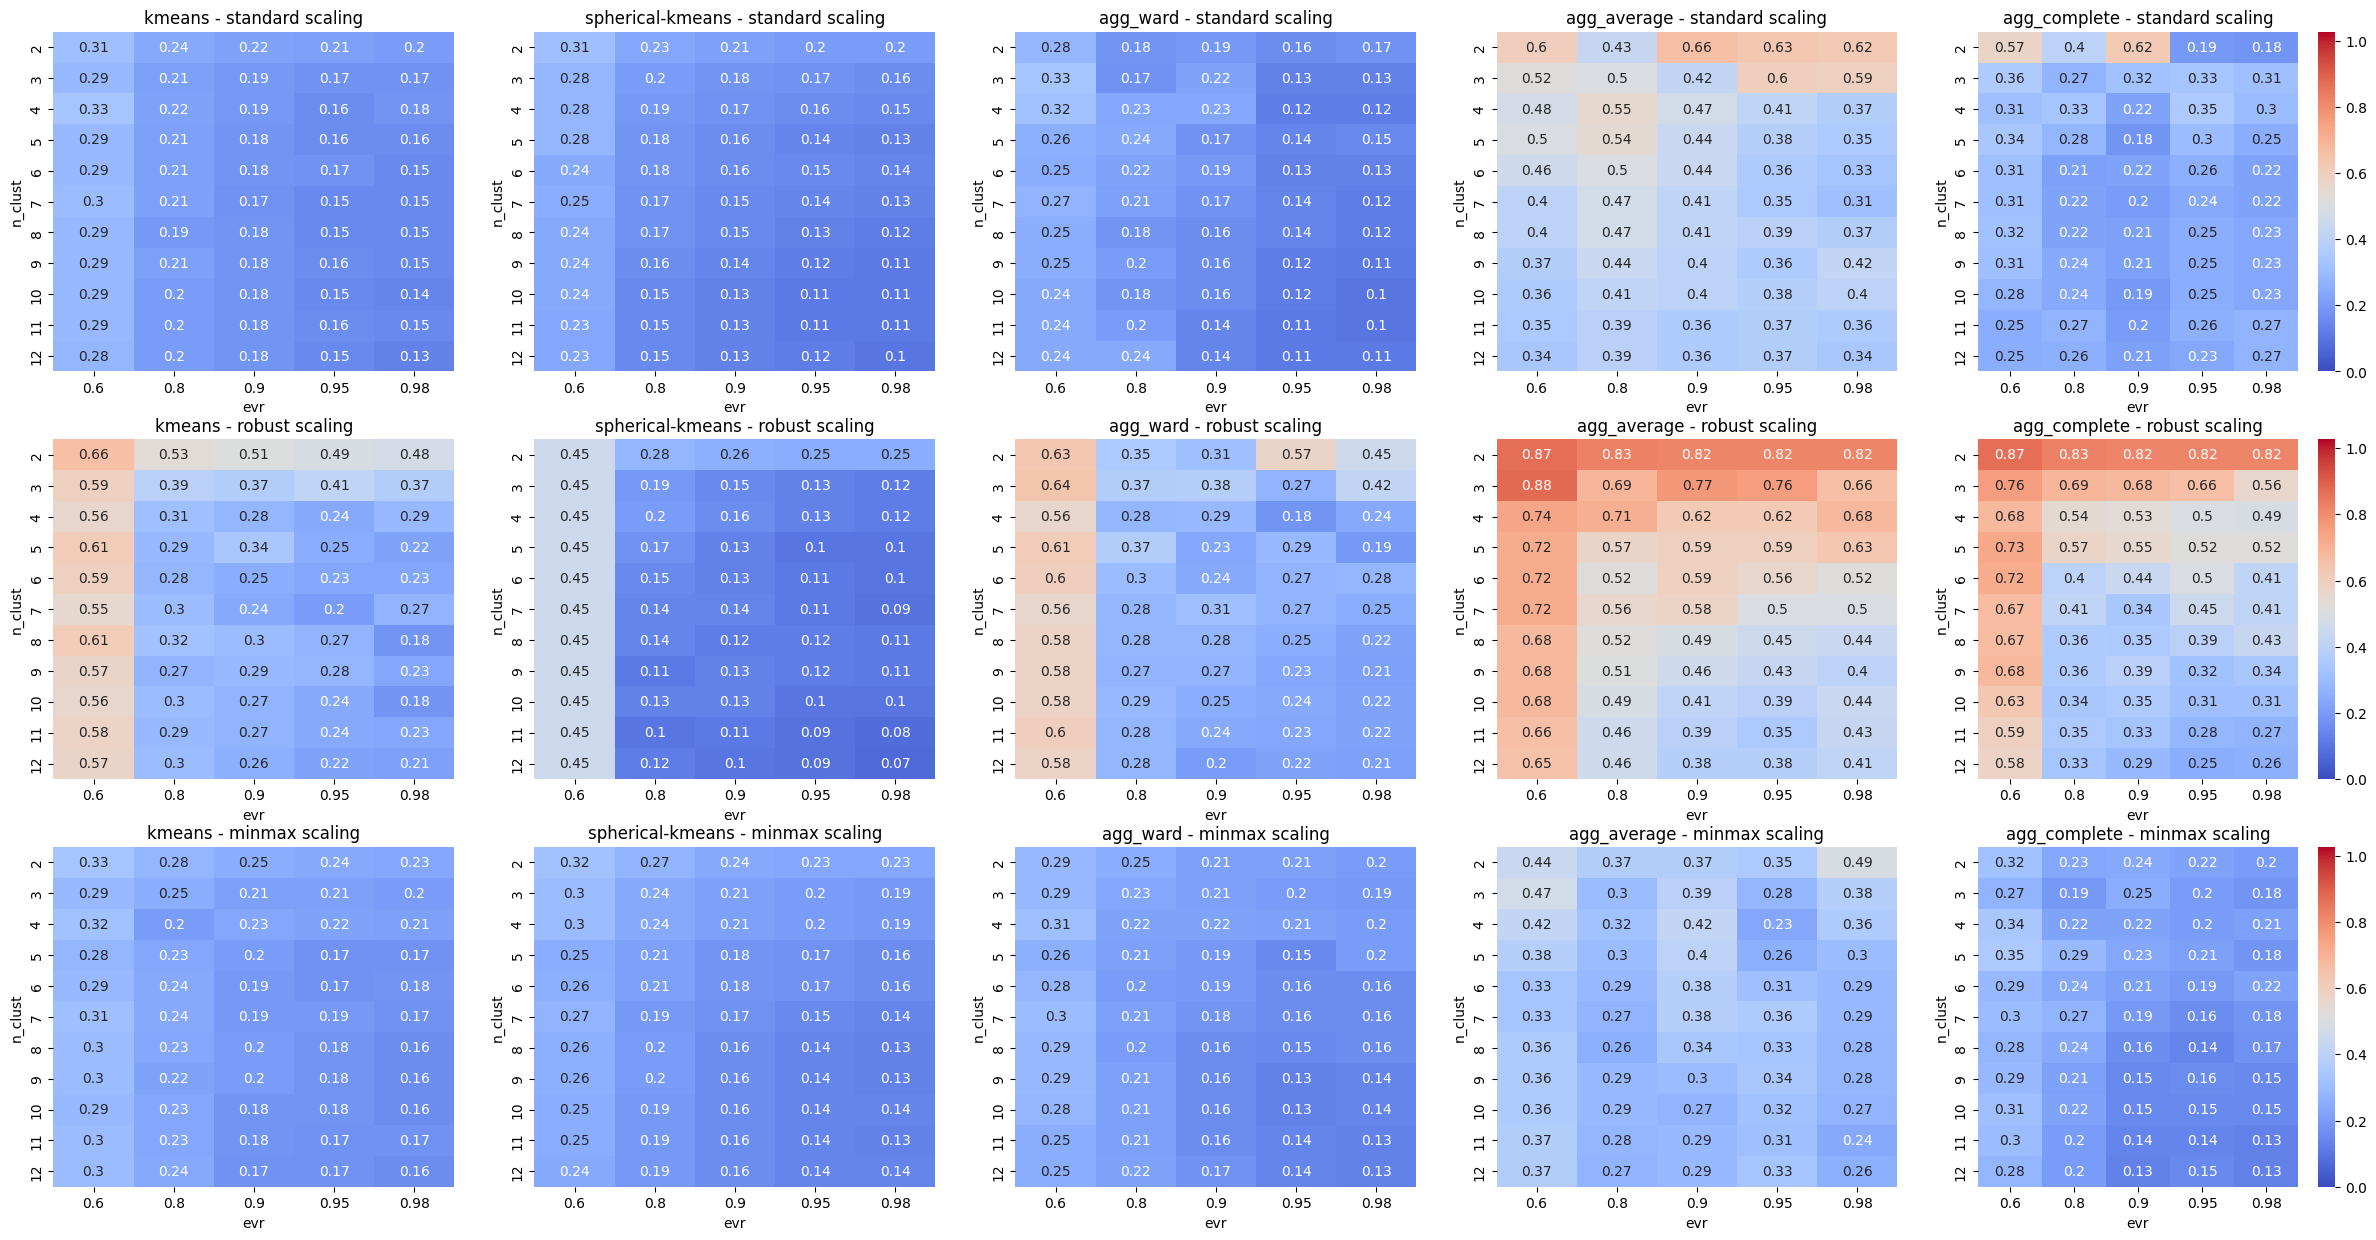

In [ ]:
scalings = cdf['scaling'].unique()
methods = cdf['method'].unique()

# metric = 'silhouette'
metric = 'silhouetteW'
# metric = 'e_w_silhouette'
# metric = 'evr_e_w_silhouette'
heatmap_kw = {'cmap': 'coolwarm', 'vmin': max(cdf[metric].min()-0.15,0), 'vmax':cdf[metric].max()+0.15, 'annot': True}
fig, axs = plt.subplots(len(scalings),len(methods),figsize = (6*len(methods),5* len(scalings)));
_cdf = cdf.groupby(['method','scaling','evr','n_clust']).agg({'n_PC':'first', metric:'max'}).reset_index()
for i, ax in enumerate(axs.flatten()) :
    method = methods[i % len(methods)]
    scaling = scalings[i // len(methods)]
    sns.heatmap(data= _cdf[(_cdf['method']==method)&(_cdf['scaling']==scaling)].pivot(index = 'n_clust', columns = ['evr'], values = metric).round(2), 
                ax = ax, **heatmap_kw, cbar = (i % len(methods)) == len(methods) -1);
    ax.set_title(f"{method} - {scaling} scaling");


Silhouette: 0.671 | SilhouetteW: 0.602 | Davies-Bouldin: 0.380 | Calinski-Harabasz: 176.599 | Ball-Hall: 111.154 | Normalized Entropy : 0.032


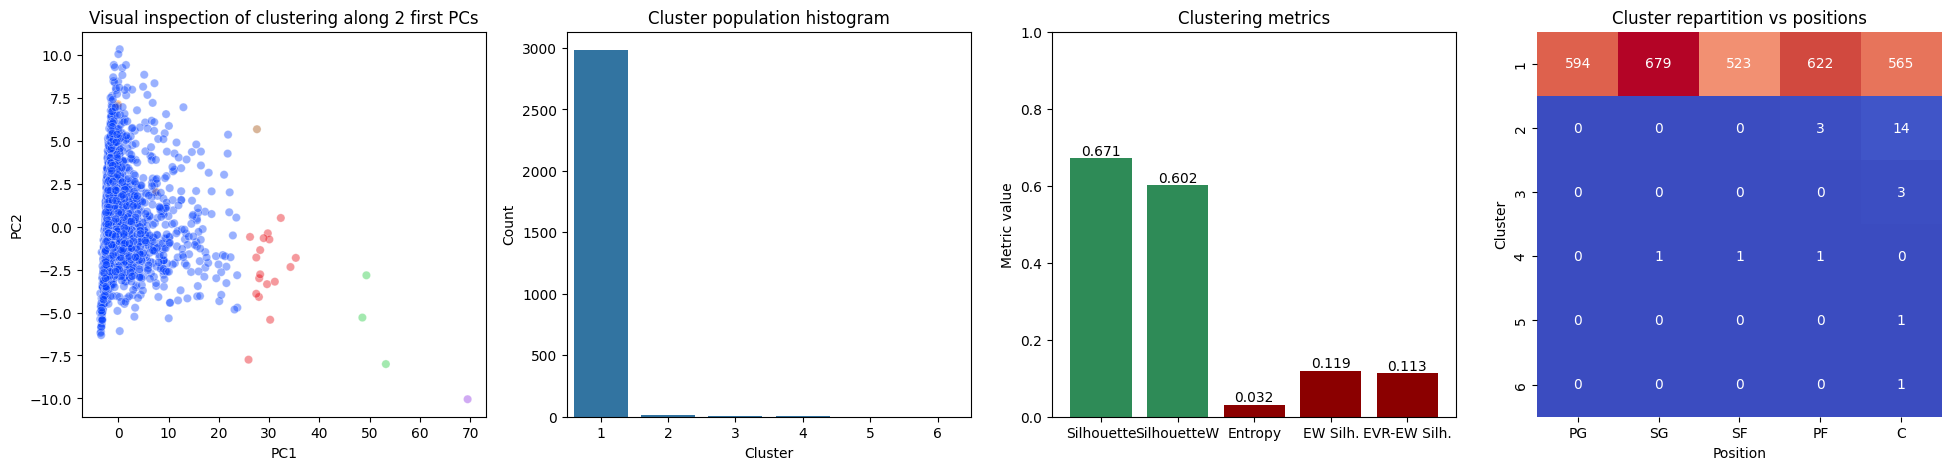

In [6]:
clusterer.plot_clustering(evr= 0.9, n_clust=6, method = 'agg_average', scaling='robust', feature_selection='incl')

### <span style = 'color:yellow'>Metrics

#### Display data 

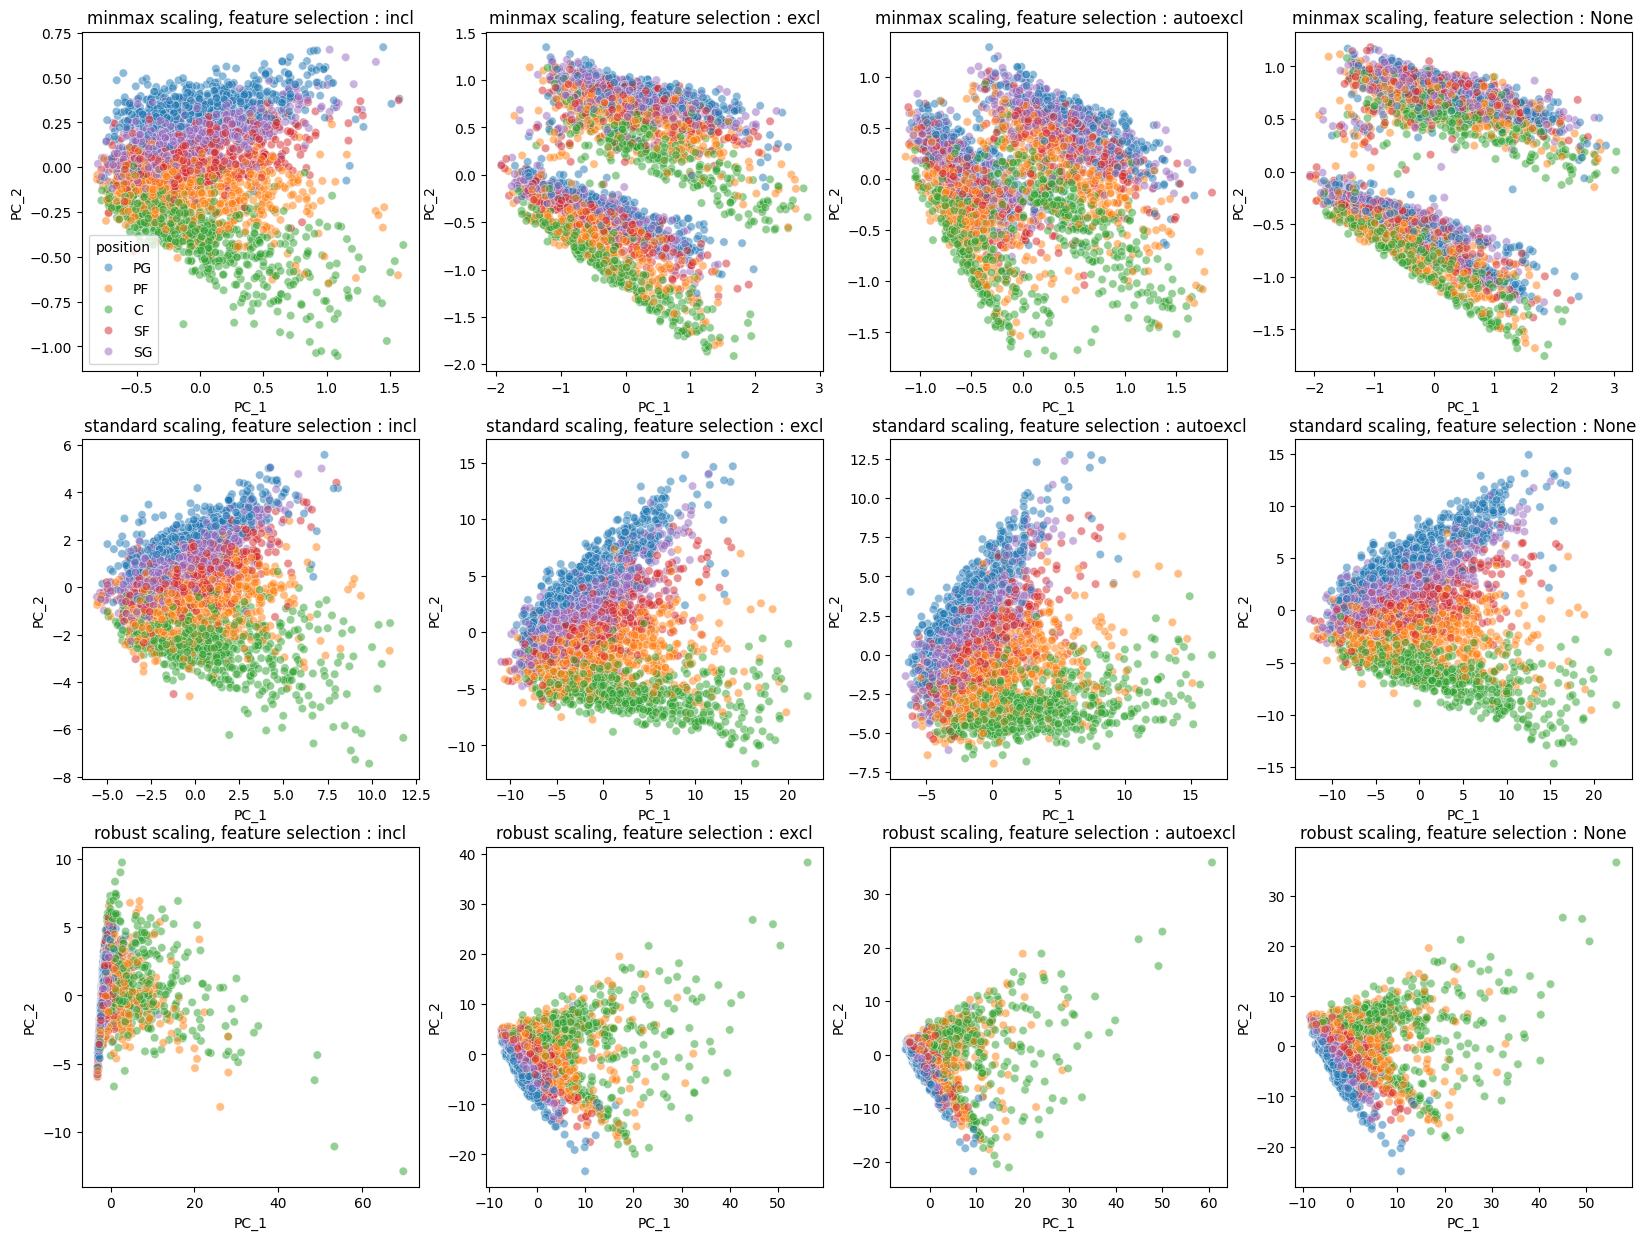

In [3]:
clusterer.plot_data()

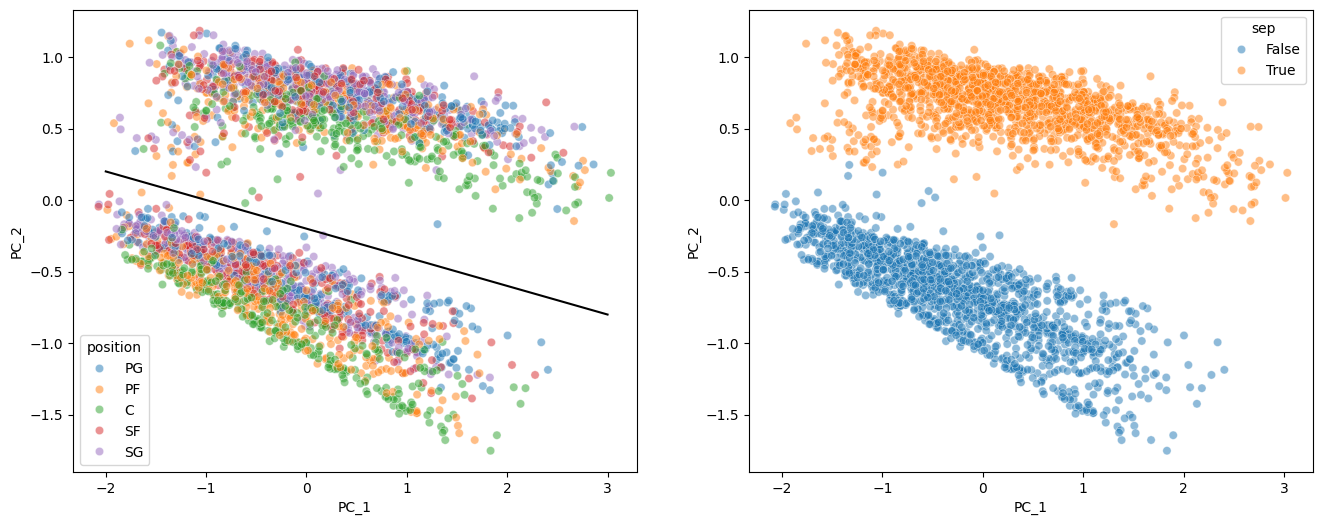

In [4]:
_df = clusterer.get_data(scaling='minmax', feature_selection= None, perform_PCA= True)
_df = _df[['PC_1','PC_2','position']]
fig, axs = plt.subplots(1,2,figsize = (16,6))
sns.scatterplot(data = _df, x = 'PC_1', y = 'PC_2', hue = 'position', alpha = 0.5, ax = axs[0]);
x0,y0 = -2, 0.2
x1, y1 = 3, -0.8
axs[0].plot([x0,x1],[y0,y1], c = 'black');
_df['sep'] = _df['PC_2'] +0.2 * _df['PC_1'] > 0
sns.scatterplot(data = _df, x = 'PC_1', y = 'PC_2', hue = 'sep', alpha = 0.5, ax = axs[1]);


In [5]:
W, pca = clusterer.get_ACP_matrix(scaling='minmax', return_PCA=True, feature_selection='incl')
W

PC_1      PC_2      PC_3      PC_4      PC_5  \
MIN                        0.442827  0.098885 -0.295990  0.193671 -0.038671   
EFG_PCT                    0.044552 -0.050158  0.002892  0.115765 -0.012856   
FG2A                       0.327980 -0.015519 -0.263472 -0.202052 -0.203058   
FG2_PCT                    0.053808 -0.144699 -0.018587  0.025201  0.101495   
FG3A                       0.184529  0.279269 -0.027505  0.444260 -0.077385   
FG3_PCT                    0.082425  0.253341 -0.010056  0.574714 -0.264687   
OFF_LOOSE_BALLS_RECOVERED  0.293277  0.021789  0.491263 -0.093512 -0.246679   
DEF_LOOSE_BALLS_RECOVERED  0.247053  0.108162  0.436659 -0.027868 -0.017209   
PFD                        0.276578 -0.008248 -0.196903 -0.144798 -0.154238   
STL                        0.301852  0.191751 -0.160875 -0.032721  0.377144   
BLK                        0.128257 -0.228498 -0.081000 -0.034879  0.059923   
DEFLECTIONS                0.314617  0.149565  0.325911 -0.023674  0.658329   
SCREEN_ASSISTS             0.122124 -0.286246  0.141759 -0.083133 -0.049559   
AVG_DRIB_PER_TOUCH         0.057772  0.540344 -0.061955 -0.554566 -0.273188   
AST_TO                     0.043481  0.205100  0.021074 -0.095031 -0.051820   
OREB_UNCONTEST             0.216822 -0.246530 -0.110778 -0.132819  0.047726   
DREB_CONTEST               0.206073 -0.365638 -0.175695 -0.002970 -0.019033   
DREB_UNCONTEST             0.283447 -0.130143 -0.134518  0.028337 -0.056462   
OFF_BOXOUTS                0.048395 -0.104327  0.089108 -0.032909 -0.101770   
DEF_BOXOUTS                0.167969 -0.249999  0.372512  0.060088 -0.332623   

                               PC_6      PC_7      PC_8      PC_9     PC_10  \
MIN                       -0.061497  0.057323  0.102289  0.251685  0.171873   
EFG_PCT                    0.178591  0.323682  0.033394 -0.102791  0.004639   
FG2A                      -0.133233 -0.056593  0.067805 -0.303344  0.035414   
FG2_PCT                    0.244404  0.793695  0.318254 -0.125680 -0.073572   
FG3A                      -0.184751 -0.060868  0.432292  0.129439  0.127133   
FG3_PCT                    0.402406 -0.031010 -0.425689 -0.323461 -0.004657   
OFF_LOOSE_BALLS_RECOVERED -0.296577  0.166400 -0.156792 -0.138323  0.125115   
DEF_LOOSE_BALLS_RECOVERED -0.298365  0.180332 -0.178912  0.019713 -0.251052   
PFD                       -0.068130 -0.068583  0.253908 -0.253449 -0.129155   
STL                        0.011458  0.033055 -0.153120  0.423407 -0.280196   
BLK                        0.048646 -0.016481 -0.128136 -0.117821 -0.298110   
DEFLECTIONS                0.238506 -0.228173  0.108980 -0.320912  0.127757   
SCREEN_ASSISTS             0.431634 -0.227526  0.216094  0.021375  0.168317   
AVG_DRIB_PER_TOUCH         0.306633  0.011556  0.037262 -0.045890  0.035773   
AST_TO                     0.306322  0.112896 -0.193532  0.324896 -0.236569   
OREB_UNCONTEST             0.041103  0.160792 -0.408598  0.191530  0.658841   
DREB_CONTEST               0.035471 -0.110741 -0.187572 -0.133162 -0.350703   
DREB_UNCONTEST            -0.004280 -0.076313 -0.052421 -0.002262 -0.094526   
OFF_BOXOUTS                0.104367 -0.046547  0.047855  0.114981  0.033574   
DEF_BOXOUTS                0.248493 -0.158202  0.221211  0.375813 -0.125787   

                              PC_11     PC_12     PC_13     PC_14     PC_15  \
MIN                        0.127648  0.127379  0.322880 -0.069216  0.073205   
EFG_PCT                   -0.013236 -0.018263 -0.010469  0.057888  0.052746   
FG2A                      -0.192863  0.504520  0.189990 -0.014963 -0.003703   
FG2_PCT                   -0.054706 -0.026232 -0.032848 -0.098700 -0.052296   
FG3A                       0.258225 -0.315804 -0.062950  0.161373 -0.037268   
FG3_PCT                   -0.220018  0.012507 -0.031681  0.010324  0.037865   
OFF_LOOSE_BALLS_RECOVERED  0.085960  0.011654 -0.369168  0.279417 -0.296444   
DEF_LOOSE_BALLS_RECOVERED -0.005574 -0.053870  0.278039 -0.189411  0.585898   


In [6]:
pc = 1
top_k = 10
display(W[[f"PC_{pc}"]].sort_values(f"PC_{pc}",ascending=False)[:top_k])
display(W[[f"PC_{pc}"]].sort_values(f"PC_{pc}",ascending=True)[:top_k])

PC_1
MIN                        0.442827
FG2A                       0.327980
DEFLECTIONS                0.314617
STL                        0.301852
OFF_LOOSE_BALLS_RECOVERED  0.293277
DREB_UNCONTEST             0.283447
PFD                        0.276578
DEF_LOOSE_BALLS_RECOVERED  0.247053
OREB_UNCONTEST             0.216822
DREB_CONTEST               0.206073

PC_1
AST_TO              0.043481
EFG_PCT             0.044552
OFF_BOXOUTS         0.048395
FG2_PCT             0.053808
AVG_DRIB_PER_TOUCH  0.057772
FG3_PCT             0.082425
SCREEN_ASSISTS      0.122124
BLK                 0.128257
DEF_BOXOUTS         0.167969
FG3A                0.184529

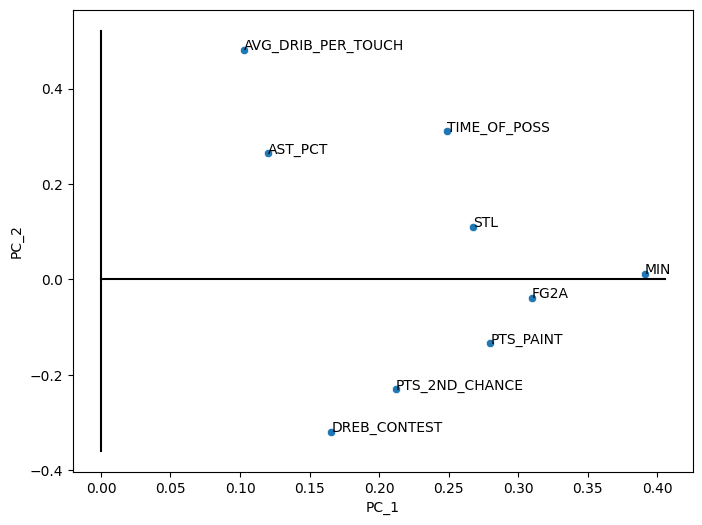

In [9]:
clusterer.plot_PCA(n_features= 8,scaling='minmax',feature_selection='incl')

In [7]:
_df.pivot_table(index = 'position', columns = 'sep', values = 'PC_1', aggfunc= 'count')

sep       False  True 
position              
C           283    301
PF          321    305
PG          306    288
SF          274    250
SG          324    356

In [35]:
_df[_df['position'] == 'SF'].sort_values('PC_2').head(15)

PC_1      PC_2 position    sep
LeBron James_2015-16           1.700759 -1.341311       SF  False
Carmelo Anthony_2014-15        1.218015 -1.279218       SF  False
Carmelo Anthony_2015-16        1.214681 -1.248151       SF  False
Andrew Wiggins_2014-15         1.040189 -1.199234       SF  False
LeBron James_2014-15           1.652461 -1.198065       SF  False
LeBron James_2016-17           2.310225 -1.152448       SF  False
Rudy Gay_2014-15               1.134230 -1.143779       SF  False
Kevin Durant_2015-16           1.388463 -1.135895       SF  False
Rudy Gay_2015-16               0.926058 -1.114812       SF  False
Andrew Wiggins_2015-16         0.996007 -1.104218       SF  False
Paul George_2015-16            1.321437 -1.101363       SF  False
Giannis Antetokounmpo_2016-17  2.097011 -1.096474       SF  False
Dahntay Jones_2015-16          0.921365 -1.095361       SF  False
Kawhi Leonard_2014-15          0.848105 -1.047538       SF  False
Kawhi Leonard_2015-16          0.951357 -1.046826       SF  False

##### Robust Scaler analysis 

In [6]:
for fs, thres in zip(['incl','excl','autoexcl'], [40,40, 36]):
    _sdf = clusterer.get_scaled_data(scaling='robust', feature_selection=fs)
    display(_sdf[_sdf['PC_1'] > thres])

PC_1      PC_2       PC_3      PC_4      PC_5  \
Andre Drummond_2017-18  49.311270 -2.439335  -4.716864 -5.912972 -1.988867   
DeAndre Jordan_2017-18  48.525156 -4.932666  -5.194094 -5.431028  0.454382   
Enes Kanter_2017-18     53.201606 -7.420678  -9.073248 -6.919385  0.586022   
Steven Adams_2017-18    69.425966 -9.340360 -11.203402 -8.197198  1.222020   

                            PC_6      PC_7      PC_8      PC_9     PC_10  ...  \
Andre Drummond_2017-18 -0.762189 -2.684410 -2.884165  3.422559  0.403830  ...   
DeAndre Jordan_2017-18 -0.998317 -3.692359 -3.483101  2.878046 -0.442690  ...   
Enes Kanter_2017-18    -0.412983 -6.201624 -4.190781  2.190373 -1.359517  ...   
Steven Adams_2017-18   -1.943977 -5.932951 -4.785808  2.884499 -1.073858  ...   

                           PC_20     PC_21     PC_22     PC_23     PC_24  \
Andre Drummond_2017-18 -0.539918 -0.339861  0.628332 -0.015162  0.950448   
DeAndre Jordan_2017-18 -1.038938  0.086020  0.657494 -0.507777 -0.492173   
Enes Kanter_2017-18    -0.340660 -1.105004 -0.289530 -0.248695  0.087861   
Steven Adams_2017-18    0.700677  0.330349 -0.137801 -0.039249  0.814879   

                           PC_25     PC_26     PC_27     PC_28     PC_29  
Andre Drummond_2017-18 -0.146067 -0.379790 -0.040100 -0.376790  0.059275  
DeAndre Jordan_2017-18 -0.789298 -0.526530  0.049833  0.131104  0.022823  
Enes Kanter_2017-18    -0.240036  0.040856  0.052627  0.127173 -0.066851  
Steven Adams_2017-18    0.134170  0.732643  0.130714  0.220777  0.233088  

[4 rows x 29 columns]

PC_1       PC_2       PC_3       PC_4       PC_5  \
Andre Drummond_2017-18  50.527884  21.440004  16.219764   6.012722   9.702180   
DeAndre Jordan_2017-18  44.799460  26.635545  17.452568   4.540911   8.713214   
Dwight Howard_2017-18   42.371370  11.587099   6.824589   9.791593   2.553499   
Enes Kanter_2017-18     49.029823  25.676962  15.614283  13.580379   1.050057   
Steven Adams_2017-18    56.231422  38.057169  22.846221   7.741419   4.516426   
Andre Drummond_2018-19  40.296603   9.990925   8.474000   1.917903  10.226069   

                             PC_6      PC_7       PC_8      PC_9     PC_10  \
Andre Drummond_2017-18  -7.888475 -0.744184  -3.165931  1.092535  0.776924   
DeAndre Jordan_2017-18  -8.701607 -1.656278  -3.629721  1.455321  2.462922   
Dwight Howard_2017-18   -6.897755 -0.194769   0.595807  2.297953 -0.563341   
Enes Kanter_2017-18    -10.935294 -0.996837  -7.314732  1.725845  0.747870   
Steven Adams_2017-18   -11.275454 -3.451263 -13.900343 -2.256861  2.470303   
Andre Drummond_2018-19  -8.237436  0.969754   2.444964  2.230723  1.608030   

                        ...    PC_107    PC_108    PC_109    PC_110    PC_111  \
Andre Drummond_2017-18  ...  0.093789 -0.109424  0.055677  0.061061  0.165586   
DeAndre Jordan_2017-18  ... -0.111711  0.015935 -0.005339  0.036933 -0.034257   
Dwight Howard_2017-18   ... -0.159031 -0.003521  0.093581  0.004385 -0.063372   
Enes Kanter_2017-18     ... -0.096898 -0.013728  0.068345  0.006337 -0.127944   
Steven Adams_2017-18    ... -0.197948  0.058261 -0.089383  0.077230  0.094387   
Andre Drummond_2018-19  ...  0.035529 -0.008115  0.041811  0.021668  0.287494   

                          PC_112    PC_113    PC_114    PC_115    PC_116  
Andre Drummond_2017-18  0.075163 -0.083360  0.090748 -0.040577  0.000029  
DeAndre Jordan_2017-18  0.071661 -0.007229  0.024727  0.002671  0.000041  
Dwight Howard_2017-18  -0.013775  0.121244 -0.096727  0.044873  0.000028  
Enes Kanter_2017-18    -0.023988 -0.112909  0.035884  0.047787  0.000008  
Steven Adams_2017-18    0.065578  0.084899  0.000400 -0.081692  0.000045  
Andre Drummond_2018-19  0.038822 -0.014717 -0.035146  0.049447  0.000030  

[6 rows x 116 columns]

PC_1       PC_2       PC_3       PC_4       PC_5  \
Andre Drummond_2017-18  49.117337  16.473196   8.587943  10.216517   5.164782   
DeAndre Jordan_2017-18  44.876854  21.501134   7.885632  10.054705   4.447787   
Dwight Howard_2017-18   39.829421   6.258073   2.269205   3.410160   8.549131   
Enes Kanter_2017-18     49.982426  22.861027   7.228382   3.901735  12.896140   
Steven Adams_2017-18    60.630849  35.850287  10.760360   6.319371   9.643737   
Andre Drummond_2018-19  38.513743   4.013038   3.906439   9.958183   1.444981   

                            PC_6      PC_7      PC_8      PC_9     PC_10  ...  \
Andre Drummond_2017-18  0.044162  0.107946 -0.790190  1.956643 -3.589169  ...   
DeAndre Jordan_2017-18 -1.559445  2.160126  1.178171  2.000163 -3.171379  ...   
Dwight Howard_2017-18   1.284281  0.155372  1.655765  1.123639 -2.213004  ...   
Enes Kanter_2017-18    -1.138535  1.667950  0.920425  2.359958 -3.790944  ...   
Steven Adams_2017-18   -4.168331  1.790199 -4.008945  4.110625 -5.842806  ...   
Andre Drummond_2018-19  0.583650 -0.983304  1.414390  1.919419 -1.539772  ...   

                           PC_63     PC_64     PC_65     PC_66     PC_67  \
Andre Drummond_2017-18  0.090636 -0.707221  0.042821  0.151370 -0.388948   
DeAndre Jordan_2017-18 -0.249346 -0.016034 -0.667153 -0.155662 -0.501871   
Dwight Howard_2017-18   0.000619  0.236369 -0.122153  0.037256 -0.787747   
Enes Kanter_2017-18     0.040911 -0.402679 -0.313203  0.291803 -0.084106   
Steven Adams_2017-18   -0.108950  0.329981 -0.152365  0.010339 -0.226072   
Andre Drummond_2018-19 -0.028816 -0.417980 -0.142749  0.565907  0.227368   

                           PC_68     PC_69     PC_70     PC_71     PC_72  
Andre Drummond_2017-18  0.114848  0.322071 -0.236436 -0.349192 -0.258051  
DeAndre Jordan_2017-18 -0.033893  0.051399  0.066792  0.102618  0.053140  
Dwight Howard_2017-18  -0.252656  0.095806  0.261451  0.153188 -0.084088  
Enes Kanter_2017-18     0.420560  0.309090 -0.093397 -0.285264  0.006881  
Steven Adams_2017-18    0.774826  0.465617  0.129010  0.201380 -0.196742  
Andre Drummond_2018-19  0.177109  0.235094 -0.164291 -0.060336 -0.259562  

[6 rows x 72 columns]

#### Highest score per metric

In [10]:
target_n_clust = 6 # Set to 2 to ignore
target_evr = 0.6 # Set to 0.4 to ignore
top_k = 10
ref_metric = 'e_w_silhouette'

top_clusterings = {}
for k,v in clusterer.metrics.items():
    _tdf = cdf[(cdf['n_clust']>= target_n_clust) & (cdf['evr']>= target_evr)].sort_values(by = k, ascending= v['ascending']).head(top_k).reset_index(drop=True)
    best_index = _tdf.sort_values(by = ref_metric, ascending=False).index[0]
    params = []
    for index,row in _tdf.iterrows():
        params.append({'feature_selection': row['feature_selection'], 'method': row['method'], 'scaling':row['scaling'], 'evr':row['evr'], 'n_clust':row['n_clust']})
    top_clusterings[k] = {'best_index':best_index, 'n_PC':_tdf.loc[best_index,'n_PC'], 'params' : params}
    item = top_clusterings[k]['params'][top_clusterings[k]['best_index']]
    print(f"n_PC : {top_clusterings[k]['n_PC']:>2}, Exp Characteristics : {item}")   

n_PC :  1, Exp Characteristics : {'feature_selection': 'incl', 'method': 'agg_average', 'scaling': 'robust', 'evr': 0.6, 'n_clust': 8}
n_PC :  1, Exp Characteristics : {'feature_selection': 'incl', 'method': 'agg_average', 'scaling': 'robust', 'evr': 0.6, 'n_clust': 8}
n_PC :  1, Exp Characteristics : {'feature_selection': 'incl', 'method': 'agg_average', 'scaling': 'robust', 'evr': 0.6, 'n_clust': 8}
n_PC :  1, Exp Characteristics : {'feature_selection': 'incl', 'method': 'kmeans', 'scaling': 'robust', 'evr': 0.6, 'n_clust': 7}
n_PC :  3, Exp Characteristics : {'feature_selection': 'incl', 'method': 'kmeans', 'scaling': 'minmax', 'evr': 0.6, 'n_clust': 7}


silhouette : Required 1 PC to reach EVR of 0.6
silhouetteW : Required 1 PC to reach EVR of 0.6
davies_bouldin : Required 1 PC to reach EVR of 0.6
calinski_harabasz : Required 1 PC to reach EVR of 0.6


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

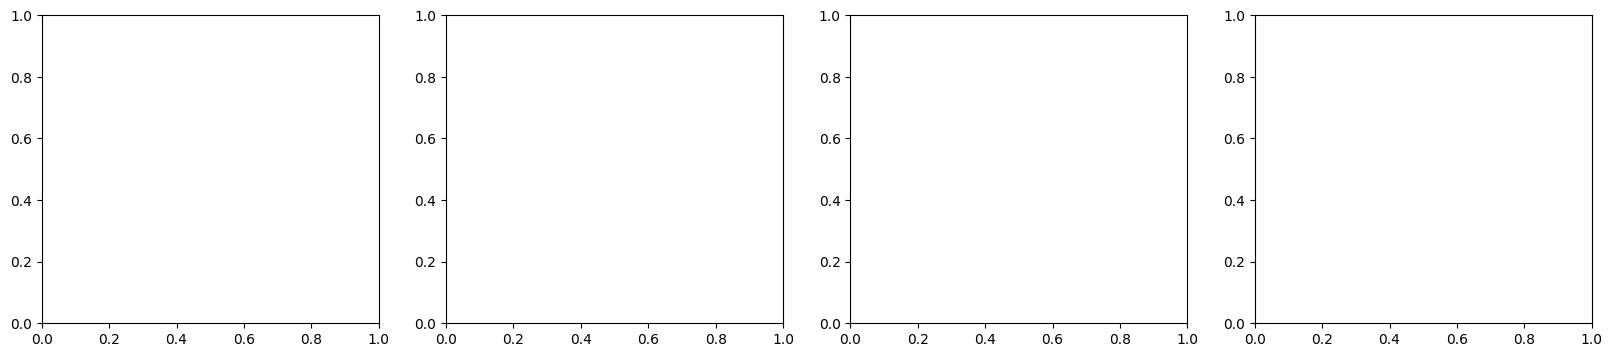

In [11]:
n_methods = len([k for k,v in top_clusterings.items() if v['n_PC'] > 1])
fig, axs = plt.subplots(n_methods,4, figsize = (20,4 * n_methods));
i = 0
annot_kws = {'xy': (0.5, 1.05), 'xytext':(0, 10), 'xycoords':'axes fraction', 'textcoords':'offset points', 'ha':'center', 'va':'bottom', 'fontsize':13, 'fontweight':'bold', 'clip_on':False}
for metric in clusterer.metrics.keys() :
    item = top_clusterings[metric]['params'][top_clusterings[metric]['best_index']]
    n_PC = top_clusterings[metric]['n_PC']
    if not n_PC == 1 :
        clusterer.plot_clustering(**item, axs =( axs[i,0], axs[i,1], axs[i,2], axs[i,3]))
        axs[i,1].annotate(f"{metric}", **annot_kws)   
        axs[i,2].annotate(f"{item['method']} | {item['scaling']} | '{item['feature_selection']}'", **annot_kws)
        i+=1
    else :
        print(f"{metric} : Required {n_PC} PC to reach EVR of {item['evr']}")
plt.tight_layout() 
plt.show() 

kmeans minmax incl
Silhouette: 0.310 | SilhouetteW: 0.312 | Davies-Bouldin: 1.002 | Calinski-Harabasz: 1444.445 | Ball-Hall: 0.694 | Normalized Entropy : 0.937


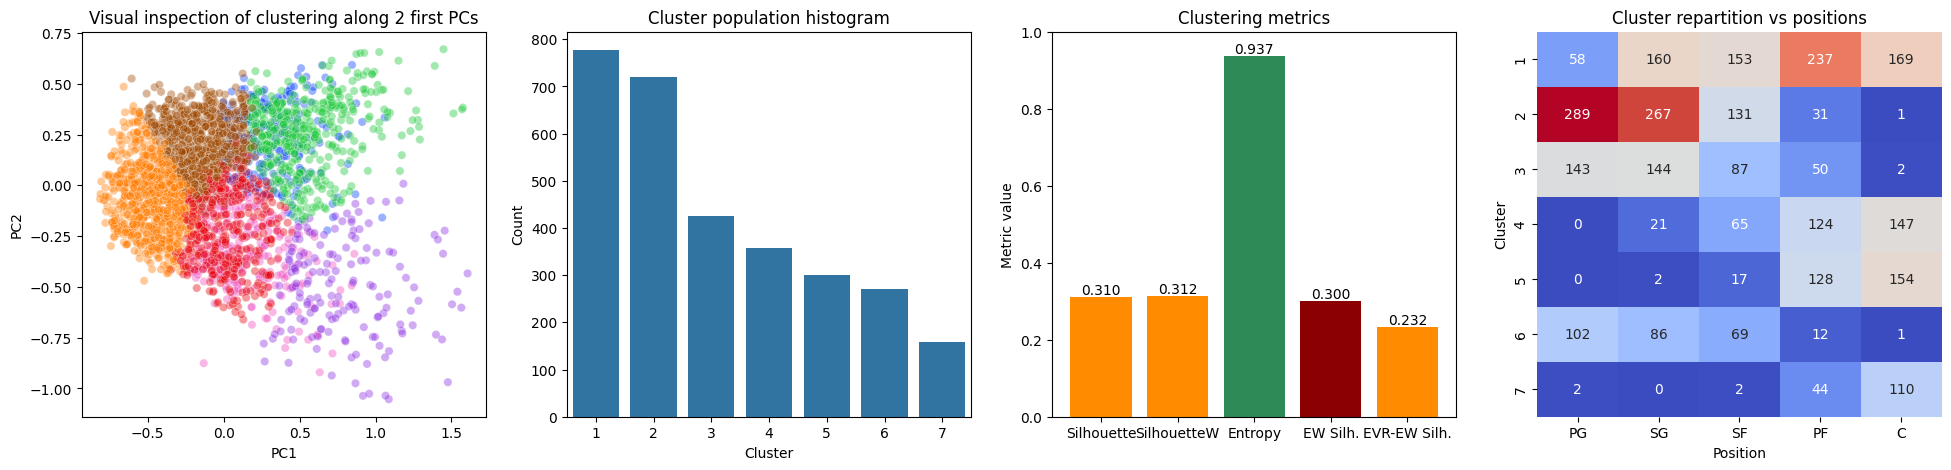

In [12]:
metric = 'ball_hall'
item = top_clusterings[metric]['params'][top_clusterings[metric]['best_index']]
print(item['method'], item['scaling'], item['feature_selection'])
X_proj, labels = clusterer.plot_clustering(**item, return_data=True)


### <span style = 'color:pink'> Analysis

In [16]:
target_silhouette = 0.3
target_entropy = 0.3
target_evr = 0.7
target_n_clust = 6

target_df = cdf[(cdf['silhouette'] >= target_silhouette)&(cdf['entropy'] >= target_entropy)&(cdf['evr'] >= target_evr)&(cdf['n_clust'] >= target_n_clust)].sort_values(metric, ascending=False)
print(f"n° of experiments corresponding the the specified results : {target_df.shape[0]}")
target_df.head()

n° of experiments corresponding the the specified results : 1


feature_selection        method scaling  evr  n_PC  n_clust  silhouette  \
434              incl  agg_complete  robust  0.9     6        7    0.369429   

     silhouetteW  davies_bouldin  calinski_harabasz   ball_hall   entropy  \
434     0.338266        1.101823         767.366507  138.222247  0.332733   

     e_w_silhouette  evr_e_w_silhouette  
434        0.213097            0.202162

Silhouette: 0.369 | SilhouetteW: 0.338 | Davies-Bouldin: 1.102 | Calinski-Harabasz: 767.367 | Ball-Hall: 138.222 | Normalized Entropy : 0.333


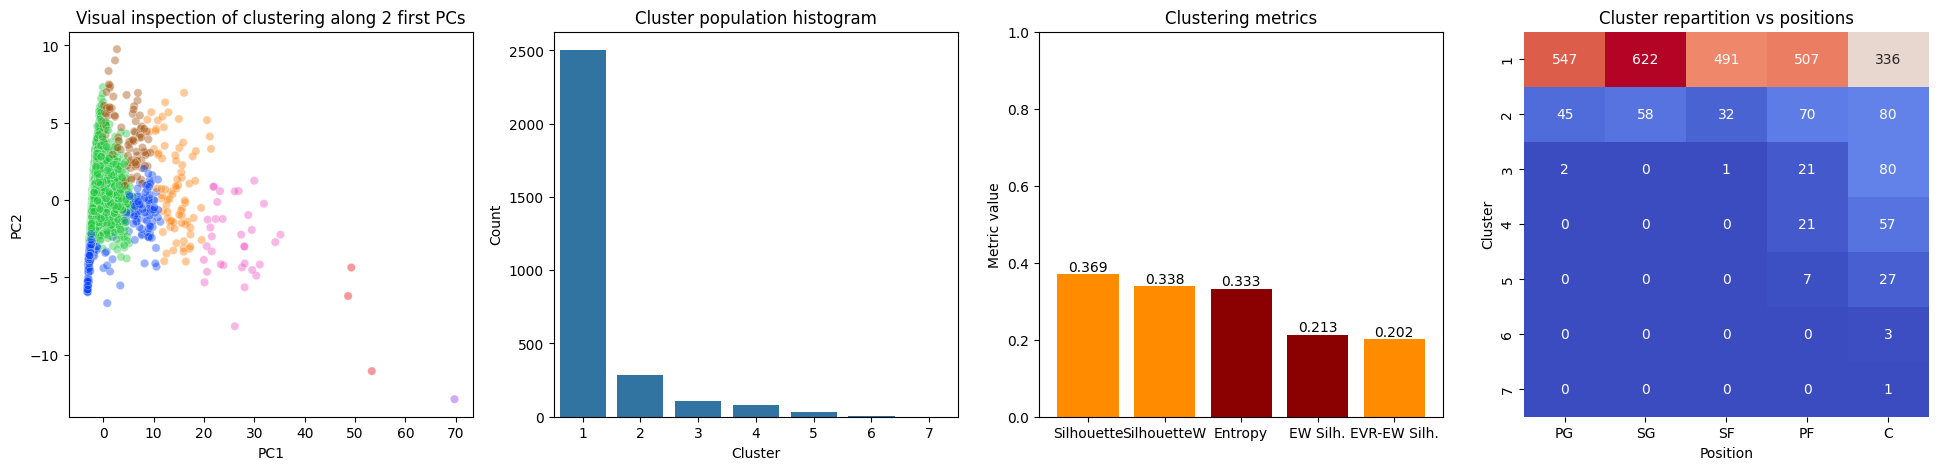

In [17]:
if target_df.shape[0] >0 :
    index = 0
    item = target_df.iloc[index][['feature_selection','method','scaling','evr','n_clust']]
    X_proj, labels = clusterer.plot_clustering(**item, return_data=True)


In [19]:
cluster_df = clusterer.feature_handler.df.copy()
cluster_df['id'] = [int(x.split('_')[0]) for x in cluster_df.index]
cluster_df['name'] = cluster_df['id'].map(pid2name)
cluster_df['position'] = cluster_df.index.map(pid2pos_bref)
cluster_df['season'] = [x.split('_')[1] for x in cluster_df.index]
cluster_df['cluster'] = labels
cluster_df['cluster'] = cluster_df['cluster'].map( (cluster_df['cluster'].value_counts() + cluster_df['cluster'].value_counts().index / 1000 ).rank(ascending=False)).astype(int)

In [20]:
SMALL_CLUSTER_LIMIT = 8
small_clusters = list(cluster_df['cluster'].value_counts()[cluster_df['cluster'].value_counts()<SMALL_CLUSTER_LIMIT].index)
# cluster_df['cluster'].value_counts()

In [21]:
cluster_df[cluster_df['cluster'].isin(small_clusters)][['name','position','season','cluster']].sort_values('cluster')

name position   season  cluster
pidSzn                                                   
203083_2017-18  Andre Drummond        C  2017-18        6
201599_2017-18  DeAndre Jordan        C  2017-18        6
202683_2017-18     Enes Kanter        C  2017-18        6
203500_2017-18    Steven Adams        C  2017-18        7

In [22]:
cluster_df[cluster_df['cluster']==1][['name','position','season','cluster']]

name position   season  cluster
pidSzn                                                     
201985_2014-15          AJ Price       PG  2014-15        1
201166_2014-15      Aaron Brooks       PG  2014-15        1
203932_2014-15      Aaron Gordon       PF  2014-15        1
203940_2014-15     Adreian Payne       PF  2014-15        1
201143_2014-15        Al Horford        C  2014-15        1
...                          ...      ...      ...      ...
1627812_2019-20     Yogi Ferrell       PG  2019-20        1
1629139_2019-20    Yuta Watanabe       SF  2019-20        1
203897_2019-20       Zach LaVine       SG  2019-20        1
1629627_2019-20  Zion Williamson       PF  2019-20        1
1629597_2019-20   Zylan Cheatham       PF  2019-20        1

[2503 rows x 4 columns]

## New development

### MeanShift

In [58]:
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score
X = clusterer.get_data(scaling='minmax',feature_selection='excl', perform_PCA=True, retrieve_name=False, retrieve_position=False)


In [67]:
bws = [1.2 + i * 0.2 for i in range(10)]

ms_res = []
for i, bw in enumerate(bws) :
    print(f"Processing attempt n° {i+1:>2} out of {len(bws):>2}", end = '\r')
    _mscl = MeanShift(bandwidth=bw).fit(X)
    n_cl = len(np.unique(_mscl.labels_))
    ms_res.append({'bandwidth':bw, 'silhouette':silhouette_score(X, _mscl.labels_) if n_cl > 1 and n_cl < X.shape[0] else 0, 'n_clust':n_cl})
_rdf = pd.DataFrame(ms_res)

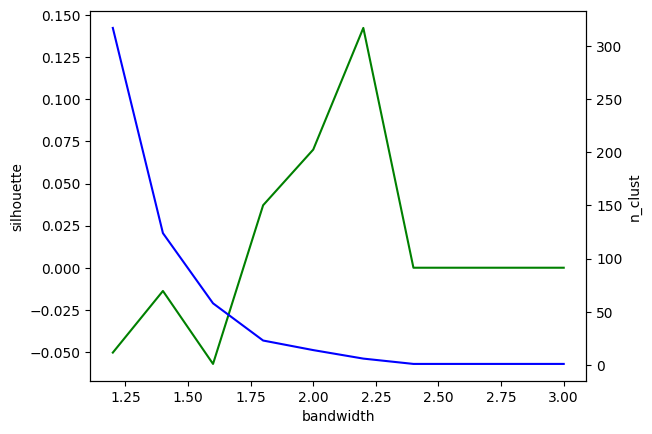

In [68]:
sns.lineplot(data= _rdf, x = 'bandwidth', y = 'silhouette', color = 'g');
ax = plt.twinx()
sns.lineplot(data= _rdf, x = 'bandwidth', y = 'n_clust', ax = ax, color = 'b');

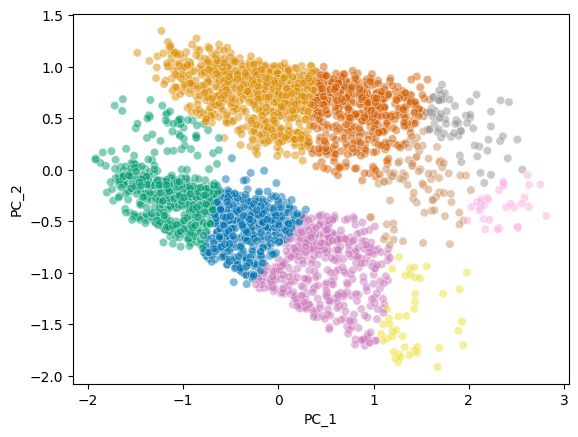

In [56]:
mscl = MeanShift(bandwidth=0.36).fit(X)
_tmp_X = X.copy()
_tmp_X['cluster'] = mscl.labels_
palette = sns.color_palette(_make_palette(np.unique(mscl.labels_)))
sns.scatterplot(data = _tmp_X, x = "PC_1", y = 'PC_2', hue = 'cluster', alpha = 0.5, palette=palette, legend = False);

### DBSCAN implementation

In [10]:
X = clusterer.get_data(scaling='minmax',feature_selection='excl', perform_PCA=True, retrieve_name=False, retrieve_position=False)
print(X.shape)
X.head(3)

(3008, 116)


PC_1      PC_2      PC_3      PC_4      PC_5      PC_6  \
pidSzn                                                                       
201985_2014-15 -0.716172 -0.322536  0.681402  0.177782  0.160239 -0.662272   
201166_2014-15 -0.188903 -0.349560  1.216232  0.387034 -0.035106  0.088615   
203932_2014-15 -0.609307 -0.586193 -0.098790 -0.164918  0.195307 -0.349678   

                    PC_7      PC_8      PC_9     PC_10  ...    PC_107  \
pidSzn                                                  ...             
201985_2014-15  0.898203 -0.338662  0.246470 -0.400883  ...  0.000813   
201166_2014-15 -0.087569 -0.063129 -0.100022 -0.169830  ... -0.008419   
203932_2014-15 -0.194530  0.017686 -0.030269  0.137519  ... -0.012542   

                  PC_108    PC_109    PC_110    PC_111    PC_112    PC_113  \
pidSzn                                                                       
201985_2014-15  0.006003  0.013693 -0.000677 -0.001709  0.003788  0.004574   
201166_2014-15 -0.004657  0.032312 -0.000735 -0.007092  0.002561  0.001201   
203932_2014-15 -0.002944  0.006191  0.004361 -0.009007 -0.001553  0.001905   

                  PC_114    PC_115    PC_116  
pidSzn                                        
201985_2014-15  0.000171 -0.000523 -0.000011  
201166_2014-15  0.002690 -0.001044 -0.000003  
203932_2014-15 -0.001187 -0.000219 -0.000002  

[3 rows x 116 columns]

In [4]:
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN


In [12]:
X = X[['PC_1','PC_2']]

/tmp/ipykernel_116580/3984832648.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['labels'] = dbscan.labels_


N° non-singletons clusters : 19, N° singletons : 160


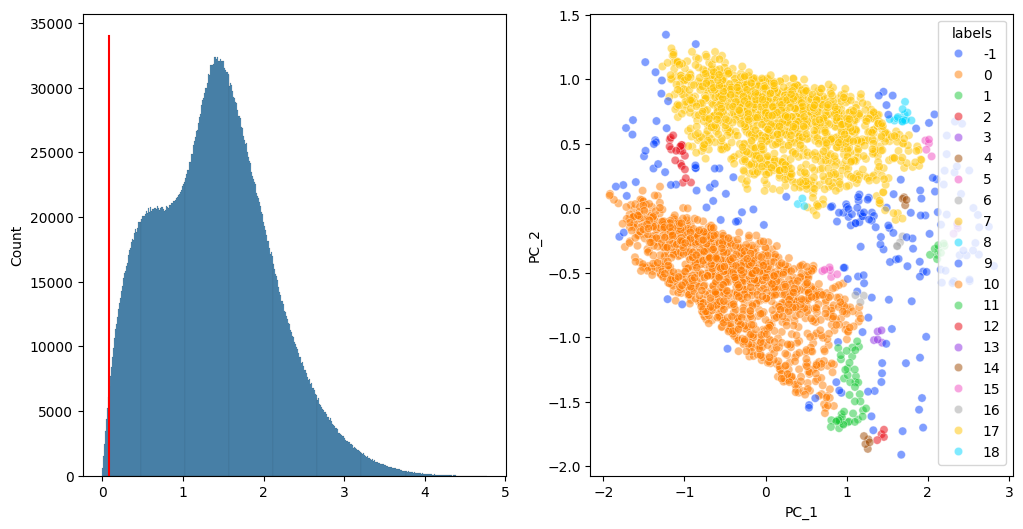

In [13]:
percentile = 0.5
n_samples = 4

D = pdist([X.loc[i] for i in X.index], metric='euclidean')
eps = np.percentile(D,percentile)
fig, axs = plt.subplots(1,2, figsize = (12,6));
sns.histplot(D, ax = axs[0]);
y0,y1 = axs[0].get_ylim();
axs[0].plot([eps,eps],[y0,y1], color = 'red');
dbscan = DBSCAN(eps,min_samples=n_samples).fit(X)
X['labels'] = dbscan.labels_
sns.scatterplot(data = X, x = 'PC_1', y = 'PC_2', hue = 'labels', alpha = 0.5, palette='bright', ax = axs[1])
print(f"N° non-singletons clusters : {X['labels'].nunique()-1}, N° singletons : {X[X['labels']==-1].shape[0]}")

In [9]:
dbscan.labels_ +4

array([3, 4, 4, ..., 3, 3, 3], shape=(3008,))

In [14]:
X_clust = X[X['labels'] != -1].groupby('labels').mean()
X_clust['origin'] = 'cluster'
X_single = X[X['labels'] == -1].copy().drop(columns='labels')
X_single['origin'] = 'single'
X_new = pd.concat([X_clust, X_single]).reset_index(drop=True)
X_new

PC_1      PC_2   origin
0   -0.397729 -0.560861  cluster
1    1.025454 -1.434012  cluster
2    1.430966 -1.761853  cluster
3    1.393328 -0.998005  cluster
4    1.251088 -1.815075  cluster
..        ...       ...      ...
174  1.739323 -0.224953   single
175 -0.625679  0.190390   single
176  1.513311 -0.133730   single
177 -1.598704  0.203326   single
178 -1.375181  0.498403   single

[179 rows x 3 columns]

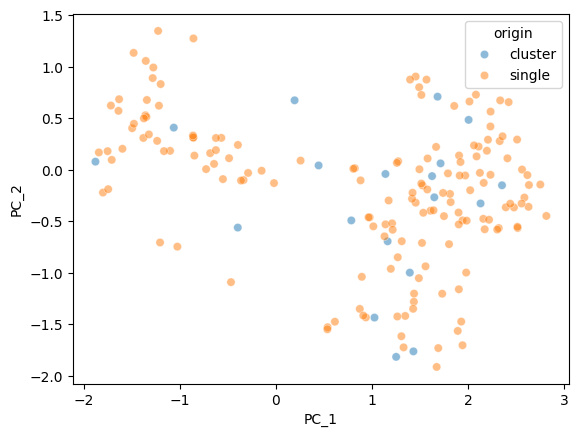

In [15]:
sns.scatterplot(data = X_new, x = 'PC_1', y = 'PC_2', hue = 'origin', alpha = 0.5);

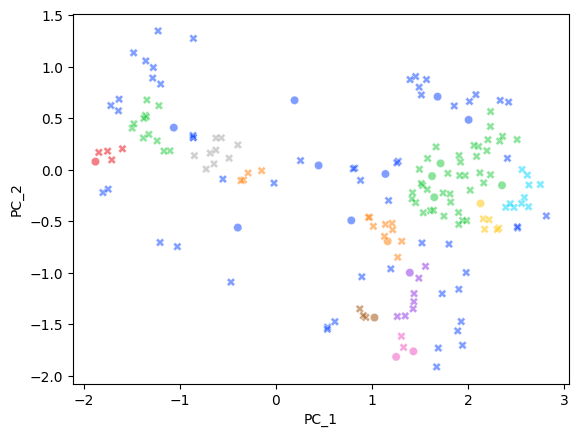

In [16]:
dbscan = DBSCAN(eps*2,min_samples=n_samples).fit(X_new[['PC_1','PC_2']])
X_new['labels'] = dbscan.labels_
sns.scatterplot(data = X_new, x = 'PC_1', y = 'PC_2', hue = 'labels', alpha = 0.5, palette='bright', style = 'origin', legend = False);

### DCIC

In [ ]:
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_score
from roster_lib.clustering.dcic import DCIC
clusterer = Clusterer(alpha= 0.5, beta = 0.5, use_positions=False)
X = clusterer.get_data(scaling='minmax',feature_selection='excl', perform_PCA=True, retrieve_name=False, retrieve_position=False)[['PC_1','PC_2']]


In [5]:
D = pdist(X)
eps_start = np.percentile(D, 0.5)
eps_max = np.percentile(D,60)
eps_start, eps_max

(np.float64(0.08366717099439025), np.float64(1.552769660599636))

In [30]:
results = []
epss = [np.round(0.04+i*0.01,2) for i in range(17)]
nss = [4,5,6,8,10,12,16,20,25,32,40,50]

n_test = len(epss) * len(nss)
for i,e in enumerate(epss):
    for j,n in enumerate(nss):
        print(f'Processing test n° {i* len(nss) + j + 1:>3} out of {n_test:>3}', end = '\r')
        _dcic = DCIC(eps_start=e, eps_max = 4, n_samples=n, eps_factor=2)
        _dcic.fit(X, verbose=False)
        if _dcic.n_clust > 1 :
            _ss = silhouette_score(X, _dcic.labels_)
        else :
            _ss = -1
        results.append({'start_eps':e, 'n_samples':n, 'n_clust':_dcic.n_clust, 'n_singles':_dcic.n_singles,'silhouette':_ss})
_rdf = pd.DataFrame(results)
        

In [31]:
_rdf.sort_values('silhouette', ascending=False).head(10)

start_eps  n_samples  n_clust  n_singles  silhouette
192       0.20          4        2          0    0.576822
180       0.19          4        2          0    0.576822
183       0.19          8        2          0    0.573407
184       0.19         10        2          0    0.568863
122       0.14          6        2          0    0.549706
187       0.19         20        2          0    0.545834
123       0.14          8        2          0    0.542650
196       0.20         10        2          7    0.540909
193       0.20          5        3          0    0.538349
181       0.19          5        3          0    0.538349

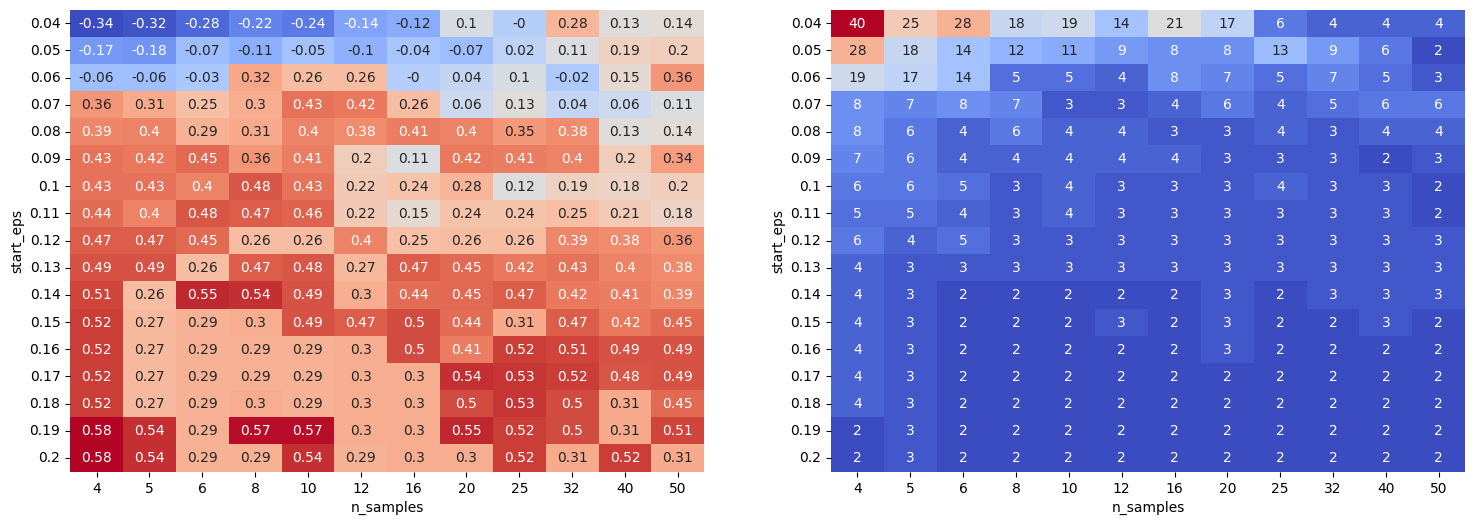

In [32]:
fig, axs = plt.subplots(1,2,figsize = (18,6))
sns.heatmap(data = _rdf.pivot(index = 'start_eps', columns = ['n_samples'], values = 'silhouette').round(2), cmap= 'coolwarm', annot = True, ax = axs[0], cbar = False);
sns.heatmap(data = _rdf.pivot(index = 'start_eps', columns = ['n_samples'], values = 'n_clust').round(2), cmap= 'coolwarm', annot = True, ax = axs[1], cbar = False);

In [33]:
eps_start = 0.08
ns = 4

dcic = DCIC(eps_start=eps_start, eps_max = 4, n_samples=ns, eps_factor=2)
dcic.fit(X)

    Cluster iter_1:0 only contains previoulsy unclustered points allocated in new cluster iter_1:0
    Cluster iter_1:3 only contains previoulsy unclustered points allocated in new cluster iter_1:1
    Cluster iter_1:5 only contains previoulsy unclustered points allocated in new cluster iter_1:2
    Cluster iter_1:1 only contains previoulsy unclustered points allocated in new cluster iter_1:3
    Cluster iter_1:2 only contains previoulsy unclustered points allocated in new cluster iter_1:4
    Cluster iter_1:4 only contains previoulsy unclustered points allocated in new cluster iter_1:5
Iteration n° 1, distance = 8.00e-02 | n non-singletons clusters : 6, n singletons : 48
    Cluster iter_2:2 comprises previoulsy identified cluster iter_1:4's centroid and uclustered points. Merged with previous cluster iter_1:4
    Cluster iter_2:1 comprises previoulsy identified cluster iter_1:5's centroid and uclustered points. Merged with previous cluster iter_1:5
    Cluster iter_2:0 only contains 

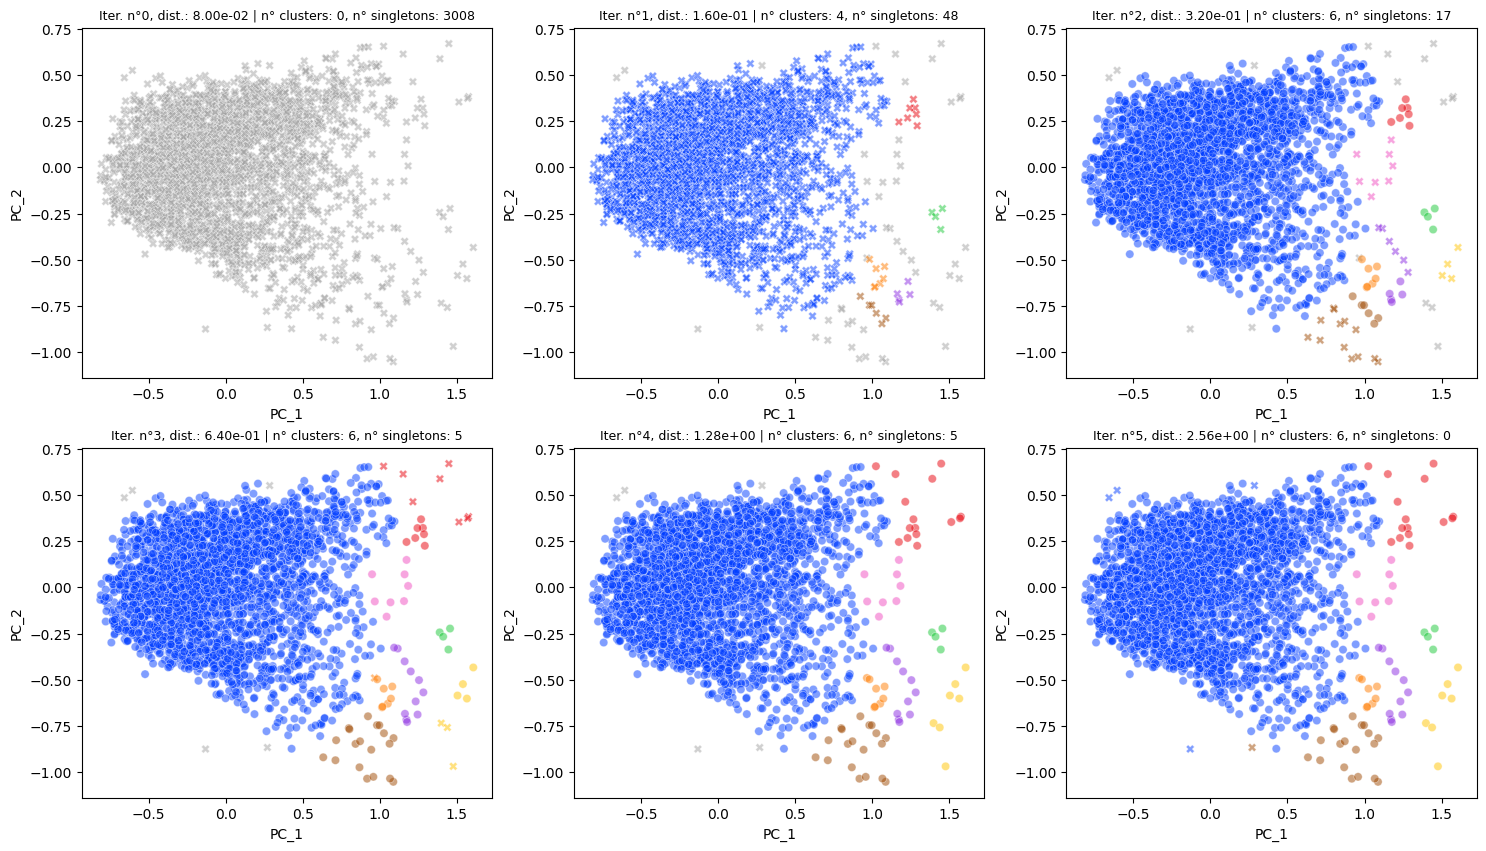

In [34]:
def plot_steps(dcic, steps= None, n_cols:int = 3):
    if steps == None:
        steps = list(range(0, dcic.iter_count+1))
    if type(steps) == int:
        steps = [steps]
    n_steps = len(steps)
    fig, axs = plt.subplots( (n_steps -1) // n_cols +1, n_cols, figsize = (6*n_cols, ((n_steps-1)//n_cols +1 )*5))
    for i, step in enumerate(steps):
        plot_step(dcic, step, ax = axs[i//n_cols,i%n_cols])

def plot_step(dcic, step:int, ax=None):
    X = dcic.clustering.copy()
    iter = f'cl_iter_{step}'
    X[f'assigned_{step-1}'] = False if (step == 0) else X[f"cl_iter_{step-1}"] != -1
    eps = dcic.start_eps * dcic.factor ** step
    labels = X[iter].unique()
    palette = sns.color_palette(_make_palette(labels))
    n_clust = (X[iter].unique() > 1).sum()
    n_singletons = X[X[iter] ==-1].shape[0]
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize = (8,6))
    sns.scatterplot(data = X, x = 'PC_1', y = 'PC_2', hue = iter, 
                    style = f"assigned_{step-1}", markers={False:'X', True:'o'}, 
                    palette=palette, alpha = 0.5, ax = ax,
                    legend= False);
    ax.set_title(f"Iter. n°{step}, dist.: {eps:.2e} | n° clusters: {n_clust}, n° singletons: {n_singletons}", fontdict={'fontsize':9});

plot_steps(dcic)
        

In [19]:
dcic.clustering

PC_1      PC_2  iter_0
0    -0.716172 -0.322536      -1
1    -0.188903 -0.349560      -1
2    -0.609307 -0.586193      -1
3    -0.066597 -1.007362      -1
4     0.793204 -1.404652      -1
...        ...       ...     ...
3003  1.709974  0.540942      -1
3004 -1.365424  0.099411      -1
3005 -1.375181  0.498403      -1
3006  1.687554 -0.080060      -1
3007 -0.766524 -0.246156      -1

[3008 rows x 3 columns]

In [6]:
X_ante['iter_2'].nunique()

24

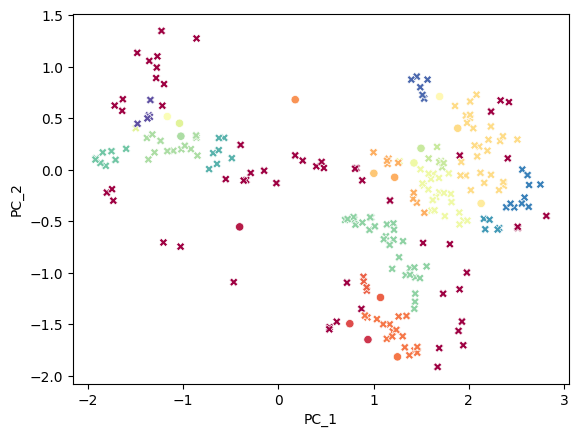

In [15]:
X_ante['clustered_1'] = X_ante['iter_1'] > -1
sns.scatterplot(data = X_ante, x = 'PC_1', y = 'PC_2', hue = 'restated', style = 'clustered_1', markers = {True:'o', False:'X'}, palette= 'Spectral',legend=False);

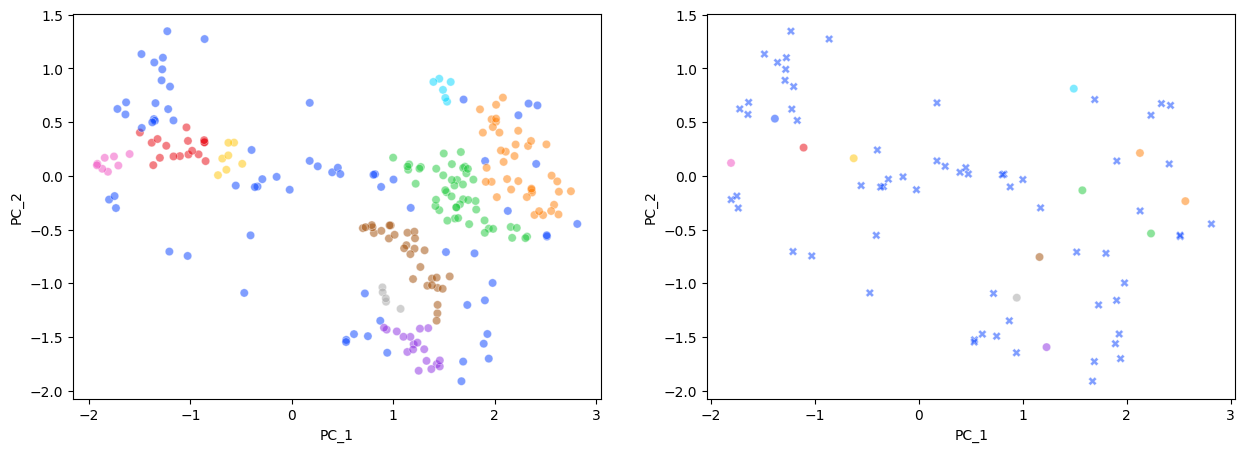

In [50]:
fig, axs = plt.subplots(1,2,figsize = (15,5));
sns.scatterplot(data = X_ante, x = 'PC_1', y = 'PC_2', hue = 'labels', alpha = 0.5, ax = axs[0], palette = 'bright',legend = False);
sns.scatterplot(data = X_post, x = 'PC_1', y = 'PC_2', hue = 'labels', alpha = 0.5, ax = axs[1], palette = 'bright',legend = False, style = 'cluster', markers = {True:'o', False:'X'});

### Partition HBDSCAN

In [ ]:
mins = [4,5,6,8,10,12,16,20,40]
mss = [5,10,20, None]
cses = [0, 0.001, 0.01, 0.1, 1, 2]
maxs = [200, 500, None]

n_test = len(mins) * len(mss) * len(cses) * len(maxs)

X = clusterer.get_data(scaling='minmax',feature_selection='excl', perform_PCA=True, retrieve_name=False, retrieve_position=False)

reslist = []
for i, min in enumerate(mins):
    for j, ms in enumerate(mss):
        for k, cse in enumerate(cses):
            for l, max in enumerate(maxs):
                n_iter = i * (len(mss) * len(cses) * len(maxs)) + j * (len(cses) * len(maxs)) + k* len(maxs) + l + 1 
                exp_details = f" | MinCS = {min:>3}, " + (f"MS = {ms:>4}, " if ms is not None else "MS = None, ") + f"CSE = {cse:.3f}, " + (f"MaxCS = {max:>3}" if max is not None else "MaxCS = None")
                print(f"Processing fir n° {n_iter:>3} out of {n_test}", end = '\r')
                _X = X.copy()
                p_hdb = PartitionHDBSCAN(min_cluster_size=min, 
                                    min_samples=ms, 
                                    cluster_selection_epsilon =cse,
                                    max_cluster_size = max,
                                    )
                p_hdb.fit(X)
                reslist.append({'min_cluster_size':min, 
                                'min_samples':ms, 
                                'cluster_selection_epsilon':cse, 
                                'max_cluster_size':max, 
                                'n_clust': p_hdb.n_clusters_, 
                                'silhouette': p_hdb.silhouette_score,
                                'silhouetteW' : p_hdb.silhouetteW_score})
_rdf = pd.DataFrame(reslist)

TypeError: unsupported format string passed to NoneType.__format__

In [ ]:
_rdf.sort_values('silhouette', ascending= False)

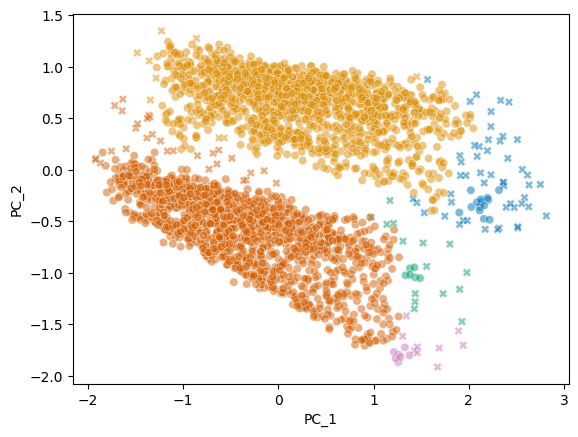

In [78]:
X = clusterer.get_data(scaling='minmax',feature_selection='excl', perform_PCA=True, retrieve_name=False, retrieve_position=False)[['PC_1','PC_2']]

p_hdb = PartitionHDBSCAN(min_cluster_size=6,
                         min_samples= None,
                         cluster_selection_epsilon= 0,
                         max_cluster_size=None)

p_hdb.fit(X)

X['labels'] = p_hdb.labels_
X['hdb_labelled'] = p_hdb.hdbscan_allocated_
sns.scatterplot(data = X, x = 'PC_1', y = 'PC_2', hue = 'labels', style = 'hdb_labelled', alpha = 0.5, palette= create_palette(p_hdb.labels_), markers={False:'X', True:'o'}, legend=False);
